# **Эксперименты с AutoML**

На парах рассказали про AutoML, теперь очень интересно попробовать. Мы вполне могли что-то упустить.

Чтобы использовать самую последнюю версию от 26th Feb 2025 нужно заморочиться. А версия постарше возрастом больше года.

In [1]:
import sys
sys.path.append('tpot-main')  # я просто zip распаковала

# pip install -e tpot-main

In [2]:
import tpot
print(tpot.__version__)

/home/ana/anaconda3/envs/tpot_automl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.0.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

np.random.seed(691)
random_state = 326

In [4]:
from tpot import TPOTClassifier

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from typing import List

In [6]:
DATA_FOLDER = "data/"
SAMPLE_METHOD = "equal"

In [7]:
# import gdown

# url = 'https://drive.google.com/uc?id=18nNEnray3VFNhnySeRaJ6fSmOAiQ3Efp'
# save_name = DATA_FOLDER + 'data_FEB25_SVD_eq_sample_128_5000.csv'
# gdown.download(url, save_name, quiet=False)

Common Fuctions

In [8]:
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from typing import Tuple

def get_metrics(y_pred, y_true, rounding=8, verbouse=True, returns=False) -> Tuple:
    """Print/Return all metrics by predictions and true values""" 

    if returns == True:
        verbouse = False

    acc = np.round(balanced_accuracy_score(y_pred, y_true), rounding)
    f1 = np.round(f1_score(y_pred, y_true, average="weighted"), rounding)
    
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
    y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2])

    # Расчет ROC-AUC для многоклассовой задачи
    auc_score = roc_auc_score(y_true_binarized, y_pred_binarized,
                            multi_class='ovr', average=None)
    
    roc_auc_metric = y.value_counts(sort=False, normalize=True) @ auc_score[::-1]
    roc_auc_metric = np.round(roc_auc_metric, rounding)
    gini = 2 * roc_auc_metric - 1
    gini = np.round(gini, rounding)

    if verbouse:
        print(f"Balanced accuracy: {acc}")
        print(f"F1-score: {f1}")
        print(f"roc_auc_score: {roc_auc_metric}")
        print(f"gini_score:{gini}")

    if returns:
        return acc, f1, roc_auc_metric, gini

### Подготавливаем данные на вход

In [9]:
df_images = pd.read_csv(DATA_FOLDER + "data_FEB25_SVD_eq_sample_128_5000.csv")
print(f"Размер выборки: {df_images.shape[0]}")

X, y = df_images.drop(columns="class"), df_images["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

Размер выборки: 5001


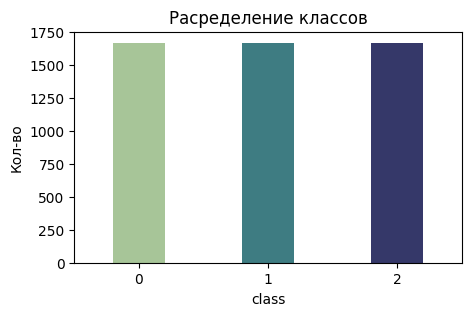

In [10]:
plt.figure(figsize = (5, 3))
sns.countplot(x=y, hue=y, legend=False, palette='crest', width=0.4,)
plt.title("Расределение классов")
plt.ylabel("Кол-во");

## **Автоподбор модели by TPOT(Tree-based Pipeline Optimization Tool)**


* по умолчанию скоринг: 'roc_auc_ovr'

* по умолчанию могут использоваться ансамбли и нейросети

* уменьшим cv с 10 до 5 для ускорения вычислений. у нас в обучающей выборке всего 4000 примеров. 10 фолдов многовато

* по умолчанию early_stop=None. Давайте заведём.

In [15]:
tpot = TPOTClassifier(
    generations=5, 
    population_size=50, 
    # verbose=1, 
    random_state=random_state, 
    cv=5, 
    early_stop=20
)

tpot.fit(X_train, y_train)

/home/ana/notebooks/courses/YEAR_PJ/checkpoint_05/tpot-main/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation:  80%|████████  | 4/5 [1:00:08<15:02, 902.15s/it] 


TPOTClassifier(cv=5, early_stop=20, random_state=326,
               search_space=<tpot.search_spaces.pipelines.sequential.SequentialPipeline object at 0x73ae587a2350>)

За час не обучилось даже первое поколение :(

In [17]:
tpot.fitted_pipeline_

Pipeline(steps=[('normalizer', Normalizer()),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.0062997107805)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('nystroem',
                                                                                 Nystroem(gamma=0.008665989162,
                                                                                          kernel='linear',
                                                                                          n_components=124,
                                                                                          random_state=326)),
                                                                                ('columnonehotencoder',
                                                                                 ColumnOneHotEncoder())])),...
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                l2_regularization=3.169e-10,
                                                learning_rate=0.0071896160622,
                                                max_features=0.4192551914042,
                                                max_leaf_nodes=1998,
                                                min_samples_leaf=50,
                                                n_iter_no_change=19,
                                                random_state=326, tol=0.0001,
                                                validation_fraction=None))])

In [19]:
pred = tpot.predict(X_test)

In [22]:
get_metrics(y_test, pred)

Balanced accuracy: 0.5895776
F1-score: 0.57742989
roc_auc_score: 0.68823322
gini_score:0.37646644


* Это не лучшая модель, но качество сопоставимое
* Надо попробовать использовать HistGradientBoostingClassifier. Уже использовали бустинги, но не конкретно этот

## **Попробуем ещё раз**

In [ ]:
tpot02 = TPOTClassifier(
    generations=10, 
    population_size=25, 
    random_state=random_state, 
    cv=5, 
    early_stop=10,
    max_time_mins = 180,
)

tpot02.fit(X_train, y_train)

/home/ana/notebooks/courses/YEAR_PJ/checkpoint_05/tpot-main/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation: 100%|██████████| 10/10 [1:30:29<00:00, 542.92s/it]


TPOTClassifier(cv=5, early_stop=10, max_time_mins=180, random_state=326,
               search_space=<tpot.search_spaces.pipelines.sequential.SequentialPipeline object at 0x76f3da6a2d70>)

In [ ]:
tpot02.fitted_pipeline_

Pipeline(steps=[('normalizer', Normalizer(norm='l1')),
                ('selectpercentile',
                 SelectPercentile(percentile=81.2966452195401)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('nystroem',
                                                                                 Nystroem(gamma=0.5718330258365,
                                                                                          n_components=106,
                                                                                          random_state=326)),
                                                                                ('columnonehotencoder',
                                                                                 ColumnOneHotEncoder())])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('extratreesclassifier',
                 ExtraTreesClassifier(class_weight='balanced',
                                      max_features=0.6375116177626,
                                      min_samples_leaf=8, min_samples_split=6,
                                      n_jobs=1, random_state=326))])

In [ ]:
y_pred = tpot02.predict(X_test)
get_metrics(y_test, y_pred)

Balanced accuracy: 0.57560255
F1-score: 0.56074349
roc_auc_score: 0.67585928
gini_score:0.35171856


Глобальные результаты
* мы частично удовлетворили свой интерес
* `модели AutoML не смогли побить качество наших моделей, но они показали приличное качество`
* самое сложное в AutoML - это решение проблем с зависимостями